# 発表資料などの資料作成に必要な素材を生成するためのノート


In [1]:
# summarized_ = return_summarized_Fixed_dataframe()
# print(summarized_)
# indices = summarized_.index.values
# columns = summarized_.columns.values
# print(indices)
# print(columns)

# plt.figure()
# for row in indices:
#     print(summarized_.loc[row].to_numpy())
#     plt.plot(columns, summarized_.loc[row].to_numpy())

# return_summarized_Fixed_dataframe(BenchMark_name="cg").to_csv("./tmp_GenerateResources/SummarizedFixedDataframe_cg.csv")

# path = "./tmp_GenerateResources/"

# def generateScoreTable(benchmark_name="cg"):
#     list_ScoreTable = []
#     dict_summary_fixed_class = return_dict_summary_fixed(benchmark_name=benchmark_name, fixed="class")
#     raw_x = dict_summary_fixed_class["processes"]
# #     print(f"raw_x : {raw_x}, benchmark : {benchmark_name}")
#     for content in dict_summary_fixed_class:
#         if(content == "processes"):
#             continue
#         raw_y = dict_summary_fixed_class[content]
#         if(does_include_nan(raw_y)):
#             continue
# #         print(f"raw_y(={content}) : {raw_y}")
#         # 線形モデル
#         model_lin = ModelLin(raw_x, raw_y, benchmark_name, content)
#         model_lin.calc_lr()
#         model_lin.calc_r2_score()
#         model_lin.calc_mae_score()
#         model_lin.calc_mse_score()
#         model_lin.calc_rmse_score()
#         model_lin.calc_mape_score()
#         model_lin.plot_graph()
#         plt.title(f"ベンチマーク名：{model_lin.benchmark_name}, 関数名：{model_lin.function_name}, MAPE : {model_lin.mape_score}", y=-0.2)
#         plt.show()
#         # logモデル
#         model_log10 = ModelLog10(raw_x, raw_y, benchmark_name, content)
#         model_log10.calc_lr()
#         model_log10.calc_r2_score()
#         model_log10.calc_mae_score()
#         model_log10.calc_mse_score()
#         model_log10.calc_rmse_score()
#         model_log10.calc_mape_score()
#         model_log10.plot_graph()
#         if(model_log10.benchmark_name == "cg" and model_log10.function_name == "MPI_Irecv()"):
#             plt.savefig(path+model_log10.benchmark_name+'_'+model_log10.function_name+'.pdf')
#         if(model_log10.benchmark_name == "cg" and model_log10.function_name == "ICNVRT"):
#             plt.savefig(path+model_log10.benchmark_name+'_'+model_log10.function_name+'.pdf')
#         plt.title(f"ベンチマーク名：{model_log10.benchmark_name}, 関数名：{model_log10.function_name}, MAPE : {model_log10.mape_score}", y=-0.2)
#         plt.show()
#         # 反比例モデル
#         model_ip = ModelIP(raw_x, raw_y, benchmark_name, content)
#         model_ip.calc_lr()
#         model_ip.calc_r2_score()
#         model_ip.calc_mae_score()
#         model_ip.calc_mse_score()
#         model_ip.calc_rmse_score()
#         model_ip.calc_mape_score()
#         model_ip.plot_graph()
#         if(model_log10.benchmark_name == "lu" and model_log10.function_name == "EXACT"):
#             plt.savefig(path+model_log10.benchmark_name+'_'+model_log10.function_name+'.pdf')
#         plt.title(f"ベンチマーク名：{model_ip.benchmark_name}, 関数名：{model_ip.function_name}, MAPE : {model_ip.mape_score}", y=-0.2)
#         plt.show()
#         list_ScoreTable.append([content, model_lin.mape_score, model_log10.mape_score, model_ip.mape_score])
#     df_ScoreTable = pd.DataFrame(list_ScoreTable)
#     df_ScoreTable.columns = ["", "x mape", "logx mape", "1/x mape"]
#     df_ScoreTable.set_index("",inplace=True)
#     df_ScoreTable

# for benchmark in benchmarks:
#     generateScoreTable(benchmark)

# # 資料作成に使用する最もフィットするモデルはどれかを示すための表・グラフを作るためのプログラム


# def return_list_of_ratio_row(input_list):
#     sum_of_input_list = 0
#     return_list = []
#     for list_child in input_list:
#         sum_of_input_list += len(list_child)
#     for list_child in input_list:
#         num = int(len(list_child)/sum_of_input_list*10000)/100
#         return_list.append(num)
#     # 総和を100にする処理
#     # 最大になることの多い線形モデルはほかのモデルの割合の総和を100から引いたものにしている
#     i_0 = 100
#     for i in range(1, len(input_list)):
#         i_0 -= return_list[i]
#     return_list[0] = i_0
#     return(return_list)

# def return_list_of_range_row(input_list):
#     return_list = []
#     for list_child in input_list:
#         if(len(list_child) == 0):
#             data_str = "(NoData)"
#         else:
#             min_data = int(min(list_child)*100)/100
#             max_data = int(max(list_child)*100)/100
#             data_str = f"({min_data}-{max_data})"
#         return_list.append(data_str)
#     return(return_list)


# def return_row_list(input_list):
#     return_list = []
#     # 割合の入ったリストと最小・最大値の入ったリスト
#     list_of_ratio_row = return_list_of_ratio_row(input_list)
#     list_of_range_row = return_list_of_range_row(input_list)
    
#     # 上の二つのリストの要素同士を結合させる
#     for i in range(len(list_of_ratio_row)):
#         return_list.append(f"{list_of_ratio_row[i]}%{list_of_range_row[i]}")
    
#     return return_list

# csv_directory_path = './tmp_GenerateResources/'

# result_of_all = [[], [], []]
# list_for_csv = []

# list_for_csv_ratio = []
# list_for_csv_range = []

# for benchmark in benchmarks:
#     result_of_benchmark = [[], [], []]
#     file_name = benchmark+'.csv'
#     file_path = csv_directory_path+file_name
#     # ファイルが存在しない場合は処理を飛ばす
#     if(os.path.isfile(csv_directory_path+file_name) == False):
#         continue
#     # 完全に値をとれたもののみで集計するようにしている
#     if(benchmark != "cg" and benchmark != "ep" and benchmark != "lu"):
#         continue
#     # 現在処理中のベンチマーク名を出力
#     print(benchmark)
#     df = pd.read_csv(file_path, index_col=0)
#     columns = df.columns.values
#     indices = df.index.values
#     for index in indices:
#         row = df.loc[index].tolist()
#         result_of_benchmark[row.index(min(row))].append(min(row))
#         result_of_all[row.index(min(row))].append(min(row))
#     list_for_csv.append([benchmark]+return_row_list(result_of_benchmark))
# list_for_csv.append(["all"]+return_row_list(result_of_all))

# print(list_for_csv)

# csv_head = ["", "線形モデル", "対数モデル", "反比例モデル"]
# df_for_csv = pd.DataFrame(list_for_csv)
# df_for_csv.columns = csv_head
# df_for_csv.set_index("")
# df_for_csv

# # ipynb形式のライブラリのインポート
# %run ./lib.ipynb

# for benchmark in benchmarks:
#     SummarizedDF= return_summarized_Fixed_dataframe(BenchMark_name =benchmark, fixed="class")
#     SummarizedDFIndex = SummarizedDF.index.tolist()
#     SummarizedDFColumns = SummarizedDF.columns.tolist()
#     x_list = SummarizedDFColumns
#     targetFunctions=["RHS", "CFFTZ", "ICNVRT", "BUBBLE"]
#     for FunctionNames in SummarizedDFIndex:
#         y_list = SummarizedDF.loc[FunctionNames].tolist()
#         if(FunctionNames in targetFunctions and (does_include_nan(y_list))==False):
#             print(f"{FunctionNames}@{benchmark}")
#             plt.figure()
#             plt.title(FunctionNames)
#             plt.plot(x_list,y_list)
#             plt.xlabel('プロセス数')
#             plt.ylabel('コール回数')
#             plt.show()
#             if(FunctionNames=="RHS"):
#                 modelLin = ModelLin(raw_x=x_list, raw_y=y_list, benchmark_name=benchmark, function_name=FunctionNames)
#                 modelLin.train_x = modelLin.raw_x
#                 modelLin.train_y = modelLin.raw_y
#                 modelLin.calc_lr()
#                 modelLin.plot_graph(save=True, fileName=f"./tmp_GenerateResources/{FunctionNames}@{benchmark}.pdf")
#             elif(FunctionNames=="BUBBLE"):
#                 modelLog10 = ModelLog10(raw_x=x_list, raw_y=y_list, benchmark_name=benchmark, function_name=FunctionNames)
#                 modelLog10.train_x = modelLog10.raw_x
#                 modelLog10.train_y = modelLog10.raw_y
#                 modelLog10.calc_lr()
#                 modelLog10.plot_graph(save=True, fileName=f"./tmp_GenerateResources/{FunctionNames}@{benchmark}.pdf")
#             elif(FunctionNames=="CFFTZ"):
#                 modelIP = ModelIP(raw_x=x_list, raw_y=y_list, benchmark_name=benchmark, function_name=FunctionNames)
#                 modelIP.train_x = modelIP.raw_x
#                 modelIP.train_y = modelIP.raw_y
#                 modelIP.calc_lr()
#                 modelIP.plot_graph(save=True, fileName=f"./tmp_GenerateResources/{FunctionNames}@{benchmark}.pdf")
#             elif(FunctionNames=="ICNVRT"):
#                 modelBranch = ModelBranch(raw_x=x_list, raw_y=y_list, benchmark_name=benchmark, function_name=FunctionNames)
#                 modelBranch.train_x = modelBranch.raw_x
#                 modelBranch.train_y = modelBranch.raw_y
#                 modelBranch.calc_lr()
#                 modelBranch.plot_graph(save=True, fileName=f"./tmp_GenerateResources/{FunctionNames}@{benchmark}.pdf")

In [2]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

↓プロセス数を固定したもの
↓ベンチマーククラスを固定したもの


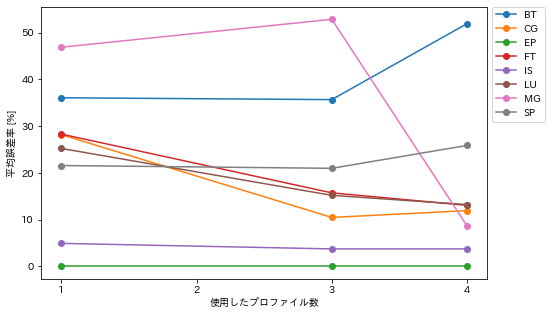

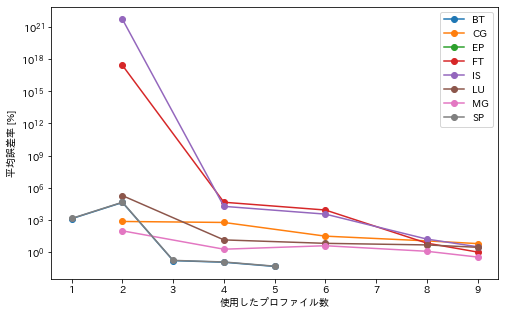

In [3]:
# 論文で必要なグラフを生成する1
print("↓プロセス数を固定したもの")
GenGraphAveragePerProfileNum(benchmarks=benchmarks, Fixed="Process", Fix=64, Predict="D", EnableTitle=False, SaveGraph=True)
print("↓ベンチマーククラスを固定したもの")
GenGraphAveragePerProfileNum(benchmarks=benchmarks, Fixed="Class", Fix="B", Predict=256, EnableTitle=False, SaveGraph=True)

bt
↓プロセス数を固定したもの
↓ベンチマーククラスを固定したもの
cg
↓プロセス数を固定したもの
↓ベンチマーククラスを固定したもの
ep
↓プロセス数を固定したもの
↓ベンチマーククラスを固定したもの
ft
↓プロセス数を固定したもの
↓ベンチマーククラスを固定したもの
is
↓プロセス数を固定したもの
↓ベンチマーククラスを固定したもの
lu
↓プロセス数を固定したもの
↓ベンチマーククラスを固定したもの
mg
↓プロセス数を固定したもの
↓ベンチマーククラスを固定したもの
sp
↓プロセス数を固定したもの
↓ベンチマーククラスを固定したもの


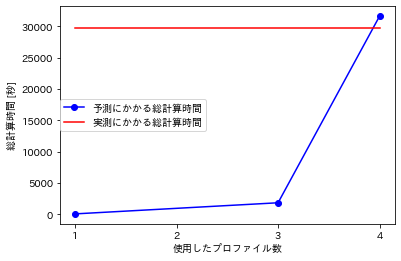

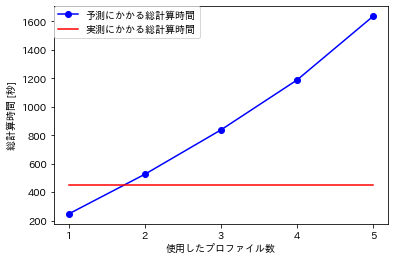

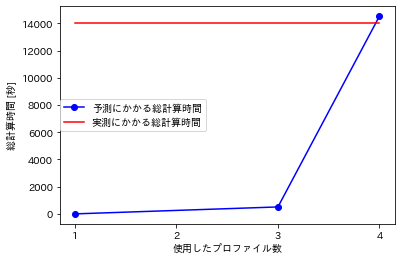

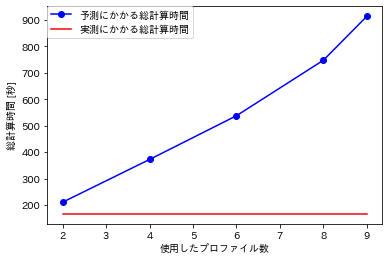

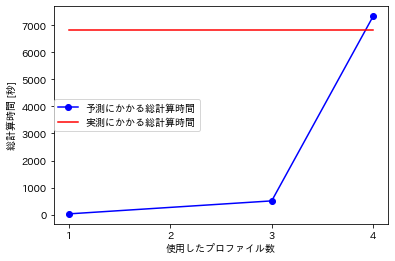

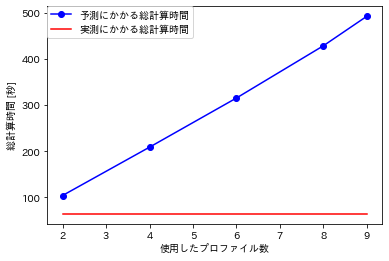

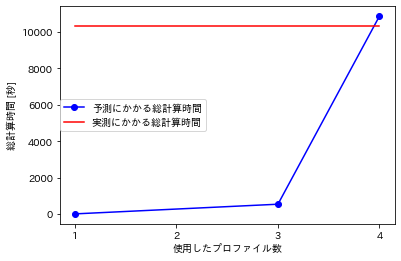

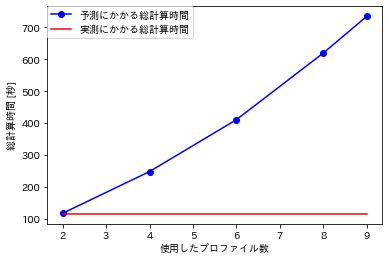

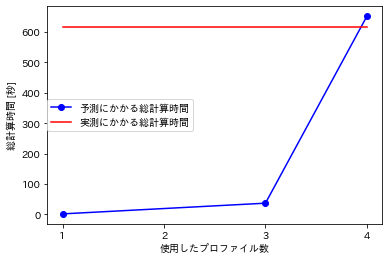

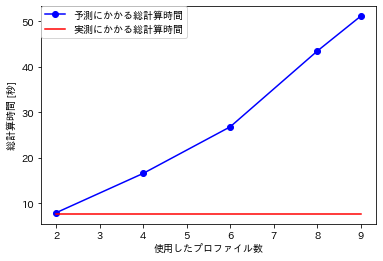

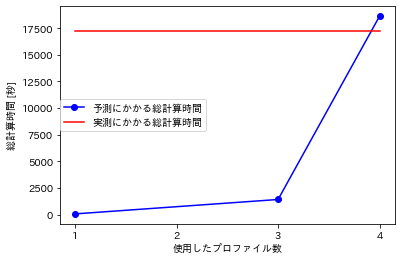

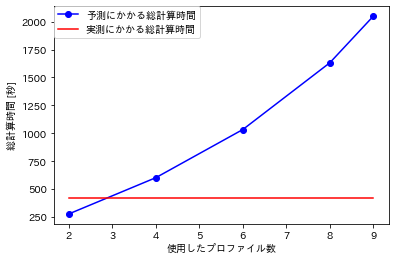

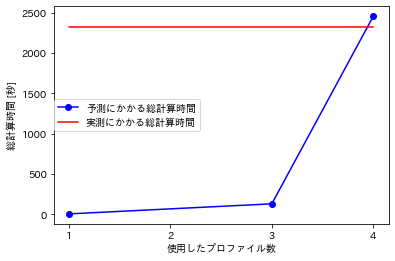

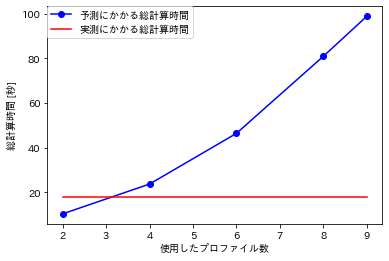

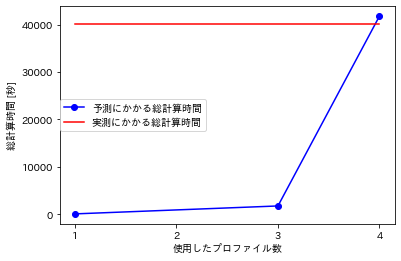

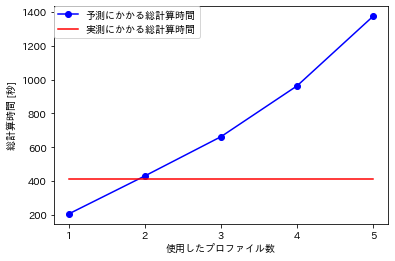

In [4]:
# 論文で必要なグラフを生成する2
for benchmark in benchmarks:
    print(benchmark)
    print("↓プロセス数を固定したもの")
    GenGraphTotalTimePerProfileNum(benchmark=benchmark, Fixed="Process", Fix=64, Predict="D", EnableTitle=False, SaveGraph=True)
    print("↓ベンチマーククラスを固定したもの")
    GenGraphTotalTimePerProfileNum(benchmark=benchmark, Fixed="Class", Fix="B", Predict=256, EnableTitle=False, SaveGraph=True)
    

# # 論文で必要なグラフを生成する3
# benchmarks01 = ['cg', 'ep', 'mg']
# benchmarks02 = ['ft', 'lu']
# benchmarks03 = ["bt", "sp"]
# benchmarks04 = ['is']
# print(f"benchmarks01 = {benchmarks01}, benchmarks02 = {benchmarks02}, benchmarks03 = {benchmarks03}")
# print(f"↓ベンチマーククラスを固定したもの@{benchmarks01}")
# GenGraphAveragePerProfileNum(benchmarks=benchmarks01, Fixed="Class", Fix="B", Predict=256, EnableTitle=True)
# print(f"↓ベンチマーククラスを固定したもの@{benchmarks02}")
# GenGraphAveragePerProfileNum(benchmarks=benchmarks02, Fixed="Class", Fix="B", Predict=256, EnableTitle=True)
# print(f"↓ベンチマーククラスを固定したもの@{benchmarks03}")
# GenGraphAveragePerProfileNum(benchmarks=benchmarks03, Fixed="Class", Fix="B", Predict=256, EnableTitle=True)
# print(f"↓ベンチマーククラスを固定したもの@{benchmarks04}")
# GenGraphAveragePerProfileNum(benchmarks=benchmarks04, Fixed="Class", Fix="B", Predict=256, EnableTitle=True)

# # 論文で必要なグラフを生成する4
# print(f"↓ベンチマーククラスを固定したもの@{benchmarks04}")
# for benchmark in benchmarks:
#     GenGraphAveragePerProfileNum(benchmarks=[benchmark], Fixed="Class", Fix="B", Predict=256, EnableTitle=False, EnableScatter=True, SaveGraph=True)

In [5]:
# ##### mgの挙動を確認するためのセル

# benchmark = "mg"
# FixClass = "B"
# predict_process = 256
# DF = return_ErrorRateFixedClassDF(benchmark=benchmark, FixClass=FixClass, predict_process=predict_process)
# DF

# lists = return_fixed_class(BenchMark="mg", Processes=[1, 2, 4, 8, 16, 32, 64, 128, 256], FixedBenchMarkClass="B")
# DF = pd.concat(lists, axis=1)
# index = DF.index.tolist()
# for i in index:
#     data = DF.loc[i].tolist()
#     if(does_include_nan(data)):
#         pass
#     else:
#         print(f"{i}:{data}")
#         plt.figure()
#         plt.plot([1, 2, 4, 8, 16, 32, 64, 128, 256], data)
#         plt.show()

In [6]:
# # benchmark = "cg"
# # benchmarks = [benchmark]
# Fix = "B"
# Predict = 256
# Fixed = "Class"

# def PlotRateOfCosts(benchmark = ["cg"], Fix="B", Predict=256, Fixed="Class"):
#     plt.figure()
#     for benchmark in benchmarks :
#         if(Fixed == "Process"):
#             DF = return_ErrorRateFixedProcess_AveragePredictCostRealCost(benchmark=benchmark, FixProcess=Fix, predict_class=Predict)
#         else:
#             DF = return_ErrorRateFixedClass_AveragePredictCostRealCost(benchmark=benchmark, FixClass=Fix, predict_process=Predict)
#         ConvertedDF = ConvertIndexNameToNumOfProfile(DF, Fixed=Fixed)
# #         print(DF)
#         x = ConvertedDF.index.tolist()
#         RealCost = DF["RealCost"].tolist()[0]
#         PredictCosts = DF["PredictCosts"].tolist()
#         y = []
#         for PredictCost in PredictCosts:
#             y.append(PredictCost/RealCost)
#         plt.plot(x, y)
        
#         plt.plot(x, [1]*len(x), label=benchmark)
#     plt.legend()
#     plt.xlabel("使用したプロファイル数")
#     plt.ylabel("予測にかかる総計算時間を実測にかかる総計算時間で割った値")
#     plt.show()
    
# PlotRateOfCosts(benchmark=benchmarks, Fix=64, Predict="D", Fixed="Process")

In [7]:
# # 論文で必要な表を生成する
# # FTの実行時間の表とFFTの実行回数の表

# # ipynb形式のライブラリのインポート
# %run ./lib.ipynb

# Classes = ["A", "B", "C", "D"]
# FunctionCalled = []
# columns = 0
# for Class in Classes:

#     Example = return_fixed_class(BenchMark="ft", FixedBenchMarkClass=Class)
#     DF = pd.concat(Example, axis=1)
#     columns = DF.columns.tolist()
#     sample = DF.T["FFT"]
#     FunctionCalled.append(sample)

# DF = pd.DataFrame(FunctionCalled)
# DF.index = Classes
# DF.to_latex("table_LatexForm/FunctionCalls.table")


# DF = pd.read_csv("csv_files/ExecTime@ft.csv", index_col=0)
# DF = DF[["1", "2", "4", "8", "16", "32", "64", "128", "256"]]
# DF = DF.T[["A", "D"]].T
# DF = DF[["8", "16", "32", "64", "128", "256"]]
# DF.to_latex("table_LatexForm/ExecTimes.table")

In [8]:
# 論文で必要な表を生成する
# 平均誤差率の表

# ipynb形式のライブラリのインポート
%run ./lib.ipynb


def returnDF_GenSummaryTable(benchmarks=["cg"], Fixed="Process", Fix=64, Predict="D"):
    ListBeforeDF = []
    for benchmark in benchmarks:
        if(Fixed=="Process"):
            FixedDF = return_ErrorRateFixedProcess_AveragePredictCostRealCost(benchmark=benchmark, FixProcess=Fix, predict_class=Predict)
            GraphTitle = f"ベンチマーク{benchmarks}で実行プロセス数を固定"
        else:
            FixedDF = return_ErrorRateFixedClass_AveragePredictCostRealCost(benchmark=benchmark, FixClass=Fix, predict_process=Predict)
            GraphTitle = f"ベンチマーク{benchmarks}でベンチマーククラスを固定"
        index = FixedDF.index.tolist()
        FixedDF = FixedDF.T[[index[1]]].T
        FixedDF.index = [benchmark.upper()]
        ListBeforeDF.append(FixedDF)
    returnDF = pd.concat(ListBeforeDF)
    return(returnDF)
    
def add_Average(DF):
    mean = DF.mean()
    mean.name = "平均"
    DF = DF.append(mean)
    return(DF)

def add_CompressionRate(DF):
    DF["時間短縮率"] = DF["予測計算時間"]/DF["実測計算時間"]*100
    DF = DF[["平均誤差率", "時間短縮率"]]
    return(DF)
    
columns = ["平均誤差率", "予測計算時間", "実測計算時間"]
FixedProcessDF = returnDF_GenSummaryTable(benchmarks=benchmarks, Fixed="Process", Fix=64, Predict="D")
FixedProcessDF.columns = columns
FixedProcessDF = add_CompressionRate(FixedProcessDF)
FixedProcessDF = add_Average(FixedProcessDF)
FixedProcessDF.to_latex("table_LatexForm/FixProcessAverageAndCosts.table")
print(FixedProcessDF)
FixedClassDF = returnDF_GenSummaryTable(benchmarks=benchmarks, Fixed="Class", Fix="B", Predict=256)
FixedClassDF.columns = columns
FixedClassDF = add_CompressionRate(FixedClassDF)
FixedClassDF = add_Average(FixedClassDF)
FixedClassDF.to_latex("table_LatexForm/FixClassAverageAndCosts.table")

print(FixedClassDF)

      平均誤差率    時間短縮率
BT  35.6674  6.22526
CG  10.4759   3.6675
EP        0  7.43345
FT  15.7267  5.24066
IS  3.74143  6.03538
LU  15.1996  8.22952
MG   52.837  5.52501
SP  20.9777  4.34185
平均  19.3282  5.83733
       平均誤差率    時間短縮率
BT  0.102775  265.188
CG   10.2528  449.171
EP         0  669.406
FT   6.30354  538.264
IS   15.0837  566.016
LU   4.27287  390.881
MG   1.08558  451.563
SP  0.108184  233.599
平均   4.65117  445.511
